In [64]:
%matplotlib inline

import os
import re
import time
import pathlib
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential

In [2]:
feature_set = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/classified_small'
data_dir = pathlib.Path(feature_set)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

7997


In [3]:
batch_size = 10
img_height = 235
img_width = 352

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 7997 files belonging to 8 classes.
Using 6398 files for training.
Found 7997 files belonging to 8 classes.
Using 1599 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255, offset=0.0)


num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [6]:
model = Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
640/640 [==============================] - 523s 814ms/step - loss: 2.0996 - accuracy: 0.1316 - val_loss: 2.0797 - val_accuracy: 0.1163
Epoch 2/3
640/640 [==============================] - 459s 717ms/step - loss: 2.0072 - accuracy: 0.1933 - val_loss: 2.0028 - val_accuracy: 0.1707
Epoch 3/3
640/640 [==============================] - 465s 727ms/step - loss: 1.9647 - accuracy: 0.2146 - val_loss: 1.9510 - val_accuracy: 0.2064


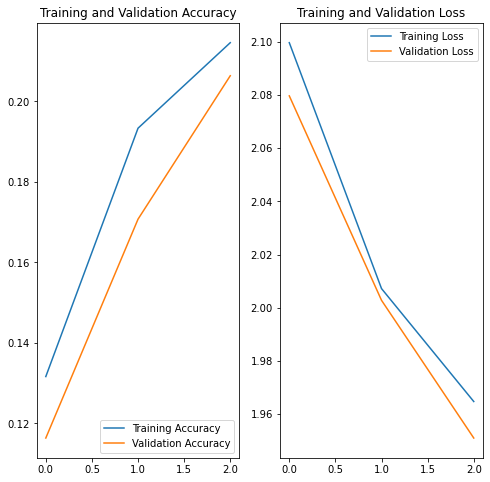

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
test_path = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/test_random/swipe_20.png'

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Rock with a 18.59 percent confidence.


In [22]:
# print(score)

for i, j in enumerate(score):
    print(class_names[i] + ": " + str(float(j)*100) + "%")

Electronic: 17.19374656677246%
Experimental: 8.713910728693008%
Folk: 7.568444311618805%
Hip-Hop: 17.11503565311432%
Instrumental: 4.966801032423973%
International: 11.781073361635208%
Pop: 14.067509770393372%
Rock: 18.593479692935944%


In [74]:
## ok so we load a chunk and generate the spectogram
## run it through the model
## use the experience to generate numbers (graph?)
## so we need a function that generates the ML scores basically

def create_images(file_name, path, save_to):
    track_no = file_name.split('.')
    track = track_no[0]

    location = os.path.join(path, file_name)

    data, sr = librosa.load(location, res_type='kaiser_fast')
    spec = librosa.feature.melspectrogram(y=data, sr=sr)
    spec_big = librosa.power_to_db(spec)
    img = librosa.display.specshow(spec_big)
    
    destination = save_to+"{}.png".format(track)
    plt.savefig(destination, bbox_inches='tight')
    plt.clf()
    
    return destination

In [98]:
def get_scores(path):
    # change img size and not having to save then load img?
    # also scores=None type beat
    
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    scores = []
    for i in score:
        scores.append(float(i))
    
    return scores
    
#     for i, j in enumerate(score):
#         data[class_names[i]] = float(j)*100
    
#     data.append(list(score), ignore_index=True)
#     data.loc[no] = scores
        
#     for i, j in enumerate(score):
#         print(class_names[i] + ": " + str(float(j)*100) + "%")

#     print(
#         "chunk {} most likely belongs to {} with a {:.2f} percent confidence."
#         .format(name, class_names[np.argmax(score)], 100 * np.max(score))
#     )

In [56]:
test_path = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/test/sample_sounds/swipe-chunked/'
save_to = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/test/sample_sounds/swipe-test/'

img = create_images('swipe_20.wav', test_path, save_to)
#plt.show()
get_scores(img)

chunk 20 most likely belongs to Rock with a 18.49 percent confidence.


<Figure size 432x288 with 0 Axes>

In [131]:
def process_song(chunks_path, images_folder):
    chunks = os.listdir(chunks_path)
    
    scores = []
    
    for p, chunk in enumerate(chunks):
#         start = time.perf_counter()
        
        dest = create_images(chunk, chunks_path, images_folder)
        data = get_scores(dest)
        
        scores.append(data)
        
#         remaining = 3-(time.perf_counter()-start)
#         time.sleep(remaining)

    df = pd.DataFrame(scores, columns=class_names)
#     print(df.head())
#     print(scores)

    return df

In [138]:
chunks_path = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/test/sample_sounds/i_got_a_boy-chunked'
images_folder = 'c:/Users/night/Documents/09/school/actual-masters/git/masters/test/sample_sounds/tests/i got a boy/'

df = process_song(chunks_path, images_folder)
df.to_csv('test.csv')

<Figure size 432x288 with 0 Axes>

[0.0490856580436229, 0.0576931089162826, 0.096792496740818, 0.1196590289473533, 0.1691957712173462, 0.165716215968132, 0.1678417325019836, 0.1689320802688598, 0.168498232960701, 0.1691470295190811, 0.1686568856239318, 0.1688711494207382, 0.1692521721124649, 0.1693433672189712, 0.1674184203147888, 0.1695550829172134, 0.1685381233692169, 0.1659730672836303, 0.1658443957567215, 0.1639567613601684, 0.164359763264656, 0.1694131940603256, 0.1686497628688812, 0.1685015112161636, 0.168614387512207, 0.1690213084220886, 0.1692315191030502, 0.1694597005844116, 0.1566143184900283, 0.1581793874502182, 0.167546346783638, 0.1658947169780731, 0.1695469915866851, 0.1722557693719864, 0.1700204163789749, 0.1687554568052292, 0.1692701280117035, 0.1708562672138214, 0.1698371022939682, 0.1672485917806625, 0.1669974625110626, 0.1673044711351394, 0.1689789295196533, 0.1684393137693405, 0.1680687814950943, 0.1689488589763641, 0.1691657453775406, 0.1686406880617141, 0.1687188744544983, 0.1691559553146362, 0.169

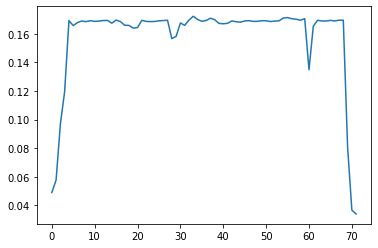

In [127]:
data = pd.read_csv('test.csv', index_col=False)

electronic = data['Electronic'].tolist()
# print(electronic)

plt.plot(electronic)
plt.show()

<AxesSubplot:>

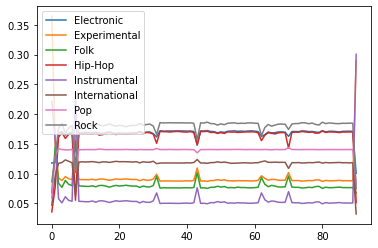

In [139]:
to_plot = class_names

data = pd.read_csv('test.csv', index_col=False)
data[to_plot].plot()